<a href="https://colab.research.google.com/github/Eastonco/CS437/blob/main/dnn-examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tensorflow Keras is a simple way to build and train neural networks in 

---

Tensorflow, so we will build example networks using this.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

2.4.1


1. Our first network performs a simple regression task using a Keras dataset to predict the price of houses in Boston (13 attributes). The network has 1 hidden layer with 20 nodes and uses mean squared error as the loss function.

57344/57026 [==============================] - 0s 0us/step

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......
Final Root Mean Square Error on validation set: 1.539


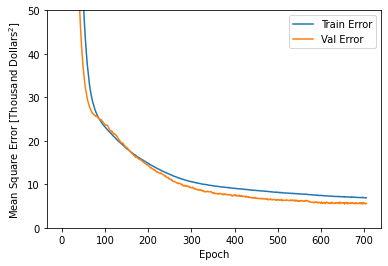

In [ ]:
(train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# get per-feature statistics (mean, standard deviation) from the training set to normalize by
train_mean = np.mean(train_features, axis=0)
train_std = np.std(train_features, axis=0)
train_features = (train_features - train_mean) / train_std

def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_features[0])]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_features, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

mse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(np.sqrt(mse_final), 3)))

# Here is a plot of the loss function values on training and testing sets.
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Thousand Dollars$^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

plot_history()

Next, we evaluate the model on holdout data. See where the reported RMSE puts the model on the Kaggle leaderboard at https://www.kaggle.com/c/boston-housing/leaderboard.

In [ ]:
test_features_norm = (test_features - train_mean) / train_std
mse, _, _ = model.evaluate(test_features_norm, test_labels)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

4/4 [==============================] - 0s 3ms/step - loss: 17.5186 - mae: 2.6057 - mse: 17.5186
Root Mean Square Error on test set: 4.186


2. Our second model is a convolutional neural network that is designed to classify images of handwritten digits found in the MNIST dataset.

MNIST contains 70k grayscale images at 28x28 resolution. There are 10 classes corresponding to digits 0..9.

11493376/11490434 [==============================] - 0s 0us/step


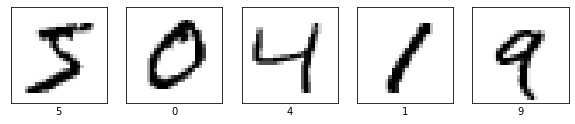

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# reshape images to specify that it's a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Scale values to [0..1] to input to NN. To do this, divide values by 255.
def preprocess_images(imgs): # should work for both a single image and multiple images
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28, 28, 1), (28, 28)], sample_img.shape # make sure images are 28x28 and single-channel (grayscale)
    return imgs / 255.0

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Look at first 5 images from the training set with their class name.
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [ ]:
# Our model has several layers stacked together.
model = keras.Sequential()
# 32 convolution filters used each of size 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# 64 convolution filters used each of size 3x3
model.add(Conv2D(64, (3, 3), activation='relu'))
# choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
# randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
# flatten since too many dimensions, we only want a classification output
model.add(Flatten())
# fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
# one more dropout
model.add(Dropout(0.5))
# output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

# We define the loss function, optimizer, and performance metric.
# Cross entropy measures the difference between two probability distributions.
model.compile(optimizer=tf.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 145s 77ms/step - loss: 0.3730 - accuracy: 0.8803
Epoch 2/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0865 - accuracy: 0.9753
Epoch 3/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0587 - accuracy: 0.9818
Epoch 4/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0501 - accuracy: 0.9850
Epoch 5/5
1875/1875 [==============================] - 144s 77ms/step - loss: 0.0418 - accuracy: 0.9866


While performance is typically low for holdout data (lower than for training data), we anticipate this model will perform well. This is because the Dropout layers add some regularization.

In [ ]:
print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

(10000, 28, 28, 1)
313/313 [==============================] - 6s 19ms/step - loss: 0.0344 - accuracy: 0.9891
Test accuracy: 0.9890999794006348


Now we use our model to predict class labels for sample images. Instead of using MNIST, we use images described at http://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/ and follow the directions there for creating morphed animations.

![MNIST dream](https://i.imgur.com/OrUJs9V.gif)

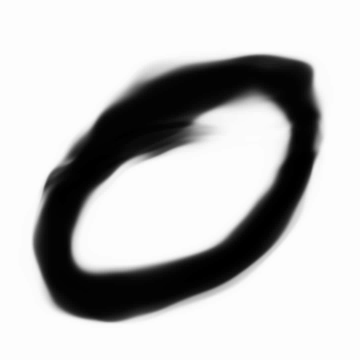

In [ ]:
# make demonstration more appealing with real-time digits classification
import urllib
urllib.request.urlretrieve("https://github.com/lexfridman/mit-deep-learning/blob/master/tutorial_deep_learning_basics/images/mnist_dream.mp4?raw=true", 'mnist_dream.mp4')

import IPython

mnist_dream_path = "mnist_dream.mp4"

def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes()
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)

cap = cv2.VideoCapture(mnist_dream_path)
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break

    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))

        # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)

cap.release()
if vw is not None:
  vw.release()

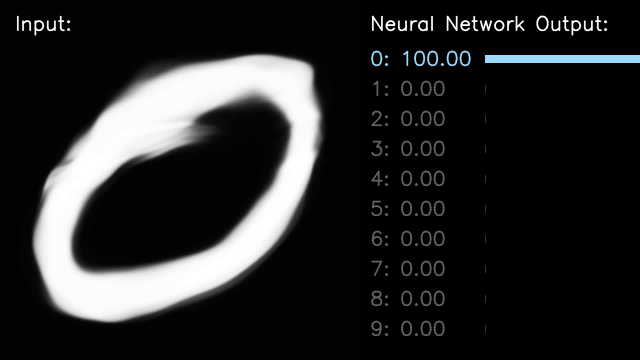

In [ ]:
def drawPrediction(img, y_pred, y_class):
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))

    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)

    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)

    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)

    y = 130
    for i, p in enumerate(y_pred):
        if i == y_class: color = (255, 218, 158)
        else: color = (100, 100, 100)

        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)

        rect_start = 230
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = "%d: %3.2f" % (i, p)
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    return img

cap = cv2.VideoCapture(mnist_dream_path)
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break

    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))

    # Pre-process the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = img_proc / 255.
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background
    img_proc = img_proc.reshape((28, 28, 1))
    img_proc = np.expand_dims(img_proc, axis=0)

    # Run Prediction
    y_pred = model.predict_proba(img_proc)[0, :]
    y_class = np.argmax(y_pred)

    img = drawPrediction(img, y_pred * 100, y_class)

    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)

cap.release()
if vw is not None:
    vw.release()

# New Section